In [136]:
import importlib

In [137]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning Primer



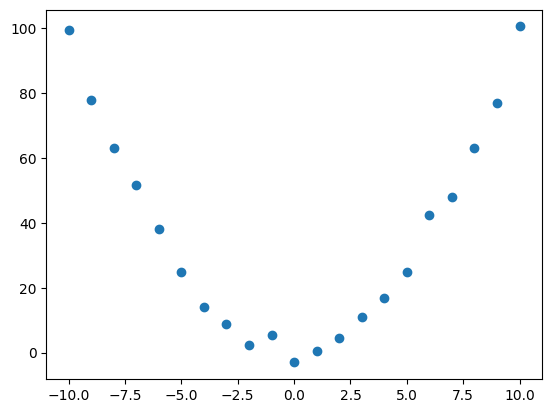

In [138]:
x = np.asarray(list(range(-10, 11)))
y = x ** 2 + np.random.normal(0, 3, 21)

plt.scatter(x, y)

 Linear regression does not work for non linear data

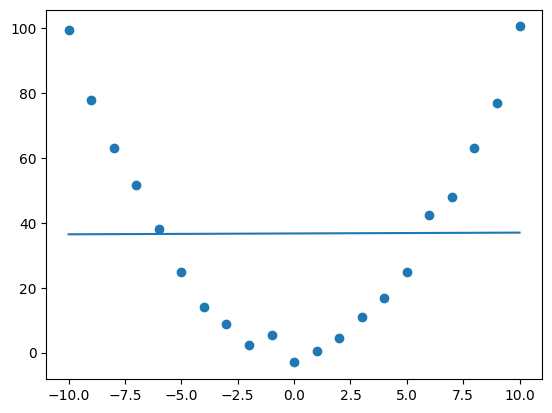

In [139]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x.reshape(-1, 1), y)

a = reg.coef_
b = reg.intercept_

pred = [a * v + b for v in x]
plt.scatter(x, y)
plt.plot(x, pred)

If we know the non linearity we can linearize the relationship
by applying it, the resulting problem becomes linear again

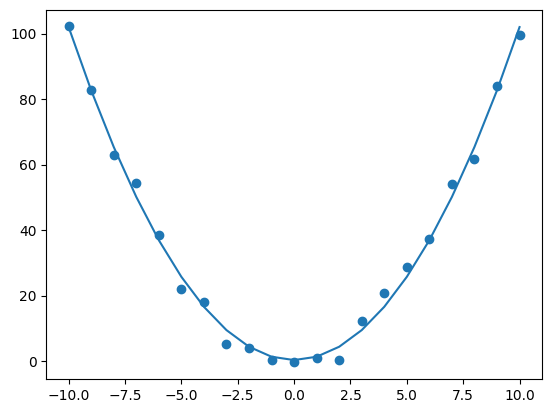

In [5]:
reg = LinearRegression().fit((x ** 2).reshape(-1, 1), y)

a = reg.coef_
b = reg.intercept_

pred = [a * v + b for v in x ** 2]
plt.scatter(x, y)
plt.plot(x, pred)

The problem is: there is an infinity of non linearities and the data can get pretty complex for find non linearity by ourself is not an option. Thankfully Neural Network can approximate any functions and thus learn the non linearity for us.

# Pytorch introduction

## Dataset

In [6]:
from torchvision import datasets
from torchvision import transforms

In [7]:
dataset = datasets.MNIST(
    '../data', 
    train=True, 
    download=True
)
print(len(dataset))

60000


In [8]:

image, label = dataset[2]
print(image.size, label)  # A Black and white image is a 2D matrix (28x28)
image

(28, 28) 4


Machine learning is all about creating a function `f` that will learn to approximate a function
For classification we want to approximate a function that will recognize the image it has been given in input

$ f(image) -> class\{ 0-9 \}$

## Linear Regression

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

size = image.size[0] * image.size[1]
n_class = 10

linear = nn.Sequential(
    nn.Flatten(),              # Flatten images from a 2D matrix to 1D => (28x28) => (784,)
    nn.Linear(size, n_class),  # Simple (a x + b) layer that will learn `a` and `b`
    nn.Softmax(dim=1)          # Normalization so result wil be between [0, 1]
)

image, label = dataset[3]
batch = transforms.ToTensor()(image) # Transform an image to a tensor/matrix
batch.shape

torch.Size([1, 28, 28])

In [10]:
list(linear.parameters()) # Show the learnable paramters for ou network

[Parameter containing:
 tensor([[ 0.0308, -0.0037, -0.0211,  ...,  0.0106, -0.0072,  0.0010],
         [ 0.0149,  0.0192, -0.0315,  ...,  0.0250,  0.0016, -0.0244],
         [-0.0195, -0.0101, -0.0304,  ...,  0.0162,  0.0177,  0.0002],
         ...,
         [-0.0164, -0.0087, -0.0262,  ...,  0.0115,  0.0061,  0.0030],
         [ 0.0054, -0.0310, -0.0246,  ...,  0.0165,  0.0072,  0.0183],
         [-0.0257, -0.0106, -0.0143,  ...,  0.0023, -0.0234, -0.0329]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0199,  0.0003,  0.0117, -0.0124,  0.0009, -0.0149,  0.0284,  0.0086,
         -0.0188, -0.0278], requires_grad=True)]

Of course the model has not been trained yet so the result below are trash.

In [11]:
image, label = dataset[3]
image

In [12]:
result = linear(batch)
print('Result:  ', result.shape)


print("\nConfidence of the image to be:")

for v, confidence in enumerate(result.tolist()[0]):
    print(f"  - {v}: {confidence* 100:5.2f}")


prediction = torch.argmax(result)
print('\nPrediction', prediction, 'Truth:', label)

Result:   torch.Size([1, 10])

Confidence of the image to be:
  - 0: 11.24
  - 1: 12.48
  - 2:  9.07
  - 3:  9.81
  - 4:  8.41
  - 5: 10.12
  - 6:  8.84
  - 7:  8.64
  - 8: 10.89
  - 9: 10.50

Prediction tensor(1) Truth: 1


# Training

In [16]:
import torch.optim as optim
import torch
import taranis.core.dataset.split as split

def train(model):
    # Takes care of spliting the dataset into bite size for our model
    dataloader = torch.utils.data.DataLoader(
        split.TransformedDatasetClassification(
            dataset, 
            transform=transforms.Compose([                    
                transforms.ToTensor(),                         # Transform the image to tensor
                transforms.Normalize((0.1307,), (0.3081,)),    # Normalize the image
            ])
        ),
        batch_size = 512,
        num_workers = 1,
    )

    # Gradient optimizer 
    optimizer = optim.Adadelta(model.parameters(), lr=0.5)
    epoch = 10

    # Repeat a few times 
    for i in range(epoch):
        total_loss = 0
        count = 0
        
        # Go through the dataset
        for batch, labels in dataloader:
            optimizer.zero_grad()                     # Clear previous derivative
            probabilities = model(batch)
            loss = F.nll_loss(probabilities, labels)
            loss.backward()                           # Compute derivative
            optimizer.step()                          # Update parameters using derivative

            total_loss += loss.item()
            count += 1
        
        print(i, 'loss: ', total_loss / count)

train(linear)

0 loss:  -0.9315457995665275
1 loss:  -0.9317384397579451
2 loss:  -0.9318875018822945
3 loss:  -0.9320262614953316
4 loss:  -0.9321591869249182
5 loss:  -0.9322878132432194
6 loss:  -0.9324128976312734
7 loss:  -0.9325349219774796
8 loss:  -0.9326542287559833
9 loss:  -0.932771081641569


In [17]:
image, label = dataset[3]

In [18]:
result = linear(batch)
print('Result:  ', result.shape)

print("\nConfidence of the image to be:")

for v, confidence in enumerate(result.tolist()[0]):
    print(f"  - {v}: {confidence* 100:5.2f}")


prediction = torch.argmax(result)
print('\nPrediction', prediction, 'Truth:', label)
image

Result:   torch.Size([1, 10])

Confidence of the image to be:
  - 0:  0.01
  - 1: 77.56
  - 2:  4.68
  - 3:  1.17
  - 4:  0.03
  - 5:  0.02
  - 6:  0.12
  - 7:  0.02
  - 8: 16.18
  - 9:  0.21

Prediction tensor(1) Truth: 1


Model is linear only so it can only approximate linear relationships
what is we create more layers ?

In [19]:
deepmodel = nn.Sequential(
    nn.Flatten(),
    nn.Linear(size, 128),  # r1 =  
    nn.Linear(128, 64),    # r2 = (x * a1 + b1) * a2 + b2
    nn.Linear(64, 10),     # r3 = x * w + b
    nn.Softmax(dim=1)      #    w = a1 * a2* a3
                           #    b = b1 * a2* a3 + b2* a3  + b3
)

batch = transforms.ToTensor()(image)
result = deepmodel(batch)
result.shape


# r3 = r2 * w3 + b3
# r3 = (r1 * w2 + b2) * w3 + b3
# r3 = r1 * w2 * w3 + b2 * w3  + b3
# r3 = (batch * w1 + b1) * w2 * w3 + b2 * w3  + b3
# r3 = batch * w1 * w2 * w3 + b1 * w2 * w3 + b2 * w3  + b3
#
# r3 = batch * w + b
#  w = w1 * w2 * w3 + b1
#  b =  b1 * w2 * w3 + b2 * w3  + b3
#
#
#   MODEL is still LINEAR
#

torch.Size([1, 10])

In [140]:
#
# Adding non linear function between 
#
deepmodel = nn.Sequential(
    nn.Flatten(),
    nn.Linear(size, 128),  # r1 = batch * w1 + b1
    nn.ReLU(),             # r2 = max(r1, 0)
    nn.Linear(128, 64),    # r3 = r3 * w3 + b3
    nn.ReLU(),             # r4 = max(r3, 0)
    nn.Linear(64, 10),     # r5 = r4 * w4 + b4
    nn.Softmax(dim=1)  
)
#
# Layers cannot be factorized anymore
#
batch = transforms.ToTensor()(image)
result = deepmodel(batch)

# How does training work ?
train(deepmodel)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x10 and 784x128)

In [21]:
#
# How can we measure how well our model is ?
#

def test_model(model):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST('../data', train=False,  transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=4096, num_workers=1) 
    total = len(dataset)
    with torch.no_grad():
        test_loss = 0
        correct = 0
        
        for batch, labels in loader:
            output = model(batch)
            test_loss += F.nll_loss(output, labels, reduction='sum').item()  
            
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(labels.view_as(pred)).sum().item()

        print('Accuracy', correct / total * 100, 100 - correct / total * 100)

In [22]:
test_model(linear)
test_model(deepmodel)

Accuracy 92.85 7.150000000000006
Accuracy 86.22 13.780000000000001


# Going faster with GPU

In [23]:
def gpu_train(original_model, batch_size=4096):
    dataloader = torch.utils.data.DataLoader(
        split.TransformedDatasetClassification(
            dataset, 
            transform=transforms.Compose([                    
                transforms.ToTensor(),                         # Transform the image to tensor
                transforms.Normalize((0.1307,), (0.3081,)),    # Normalize the image
            ])
        ),
        batch_size = batch_size,
        num_workers = 1,
    )

    device = torch.cuda.current_device()               # HERE Get GPU device
    model = original_model.to(device)                  # HERE
    optimizer = optim.Adadelta(model.parameters(), lr=1)
    epoch = 10

    for i in range(epoch):
        losses = []
        count = 0
        for batch, labels in dataloader:
            batch, labels = batch.to(device), labels.to(device) # HERE

            optimizer.zero_grad()
            probabilities = model(batch)
            loss = F.nll_loss(probabilities, labels)
            loss.backward()
            optimizer.step()

            losses.append(loss.detach())
            count += 1
        total_loss = (sum(losses) / count).item()
        print(i, total_loss / count)
    
def gpu_test_model(model):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST('../data', train=False,  transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=4096, num_workers=1) 
    total = len(dataset)
    device = torch.cuda.device("cuda:0")  # HERE
    model = model.to(device=device)       # HERE
    with torch.no_grad():
        test_loss = 0
        correct = 0
        
        for batch, labels in loader:
            batch, labels = batch.to(device), labels.to(device) # HERE
            
            output = model(batch)
            test_loss += F.nll_loss(output, labels, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(labels.view_as(pred)).sum().item()

        print('Accuracy', correct / total * 100)

# Back to x^2

In [144]:
model = nn.Sequential(
    nn.Linear(1, 2),  
    nn.ReLU(),             
    nn.Linear(2, 1), 
)

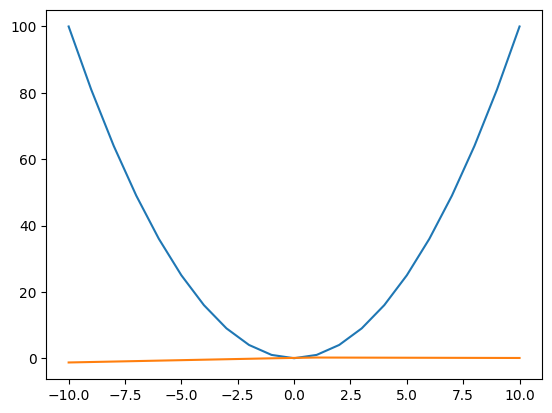

In [145]:
x = np.asarray(list(range(-10, 11)))
y = x ** 2

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
output = torch.tensor(y, dtype=torch.float).unsqueeze(1)
pred = model(input).detach().numpy()

plt.plot(x, y)
plt.plot(x, pred)

In [146]:
def train(model, epoch=100):
    optimizer = optim.Adadelta(model.parameters(), lr=1)

    for i in range(epoch):
        optimizer.zero_grad()
        pred = model(input)
        loss = F.mse_loss(pred, output)
        loss.backward()
        optimizer.step()

        if i % (epoch / 10) == 0:
            print(loss.item())
            
train(model, 2000)

2445.14794921875
557.2130737304688
171.22781372070312
122.97209930419922
74.75834655761719
42.245033264160156
23.025548934936523
18.797643661499023
18.0446720123291
17.997817993164062


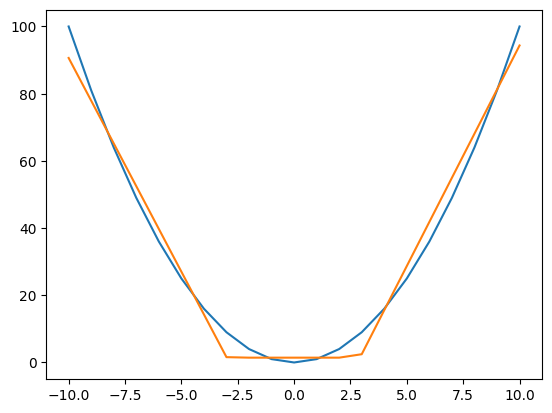

In [147]:
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

# Increase number of neurons

2346.236083984375
64.41105651855469
35.415916442871094
26.441734313964844
20.836355209350586
16.583608627319336
13.604090690612793
10.756078720092773
9.131817817687988
7.221287250518799


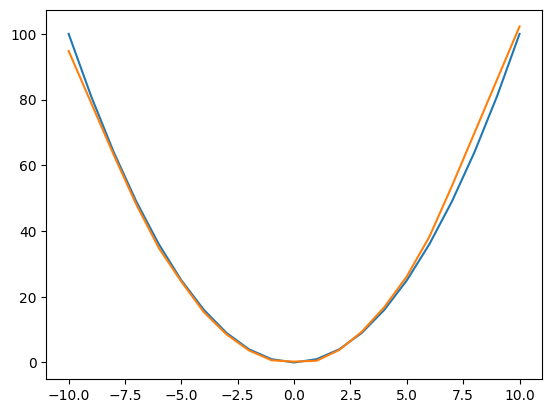

In [154]:
model = nn.Sequential(
    nn.Linear(1, 128),  
    nn.ReLU(),             
    nn.Linear(128, 1), 
)
train(model, 2000)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

# Non Linear correlation

In [29]:
# Regular linear Correlation does not work well shows x, y are essentially not correlated
print(np.corrcoef(x, y))

[[ 1.00000000e+00 -2.73542223e-17]
 [-2.73542223e-17  1.00000000e+00]]


In [30]:
pred = model(input).detach().squeeze().numpy()

#
# Correlation is essentially one
#
print(np.corrcoef(pred, y))

[[1.       0.995941]
 [0.995941 1.      ]]


# Generalization

Current models are not able to learn or infer outside of the training set
if we increase the domain of the function from $[-10, 10]$ we can see that the error will keep increasing.

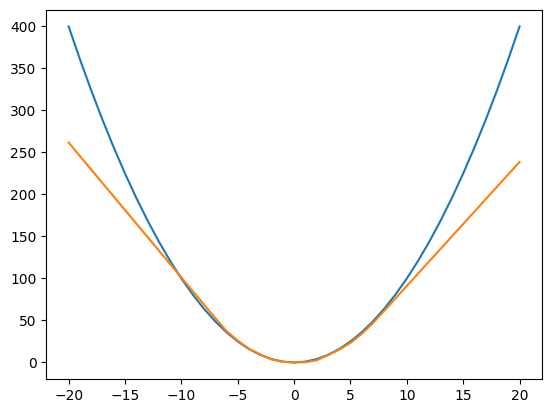

In [31]:
x = np.asarray(list(range(-20, 21)))
y = x ** 2

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

# With sin the issue is more obvious

0.7205145359039307
0.022593144327402115
0.016654973849654198
0.012416825629770756
0.009460732340812683
0.007433958351612091
0.006002630572766066
0.004981715697795153
0.004237849730998278
0.003738619387149811


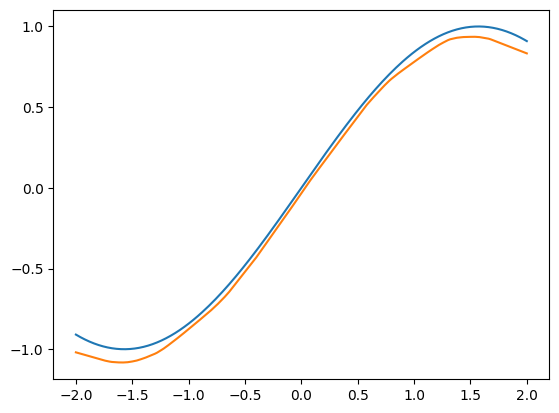

In [32]:
x = np.asarray(list(range(-100, 101))) / 50
y = np.sin(x)

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
output = torch.tensor(y, dtype=torch.float).unsqueeze(1)

model = nn.Sequential(
    nn.Linear(1, 128),  
    nn.ReLU(),             
    nn.Linear(128, 1), 
)

train(model, 2000)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

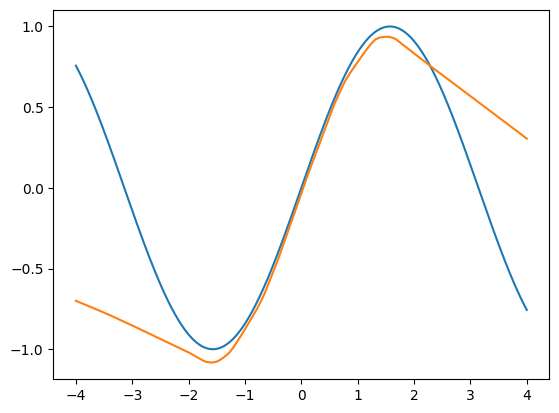

In [33]:
x = np.asarray(list(range(-200, 201))) / 50
y = np.sin(x)

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

0.9349488019943237
0.16909538209438324
0.10347219556570053
0.06422438472509384
0.04270165413618088
0.03227875381708145
0.026794424280524254
0.023900127038359642
0.02327895723283291
0.024362942203879356


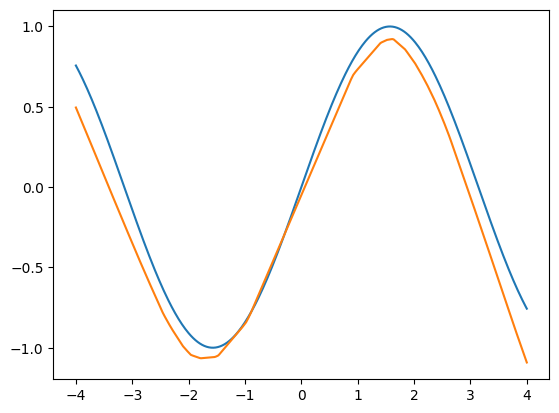

In [34]:
x = np.asarray(list(range(-200, 201))) / 50
y = np.sin(x)

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
output = torch.tensor(y, dtype=torch.float).unsqueeze(1)

model = nn.Sequential(
    nn.Linear(1, 256),  
    nn.ReLU(),             
    nn.Linear(256, 1), 
)

train(model, 2000)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

# Different Layers

Linear layers are quite resource intensive often we will use specialized layer for some specific data.
For example, images will often use convolution layers.

Convolution apply a filter on an image and produce another image https://fr.wikipedia.org/wiki/Noyau_(traitement_d%27image)

In [35]:
image, label = dataset[2]
print(image.size, label)  # A Black and white image is a 2D matrix (28x28)
image

(28, 28) 4


In [36]:
conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
print(conv.weight.shape)

batch = transforms.ToTensor()(image)
print(batch.shape)
result = conv(batch)
print(result.shape)

torch.Size([32, 1, 3, 3])
torch.Size([1, 28, 28])
torch.Size([32, 26, 26])


Example of images generated from a convolution

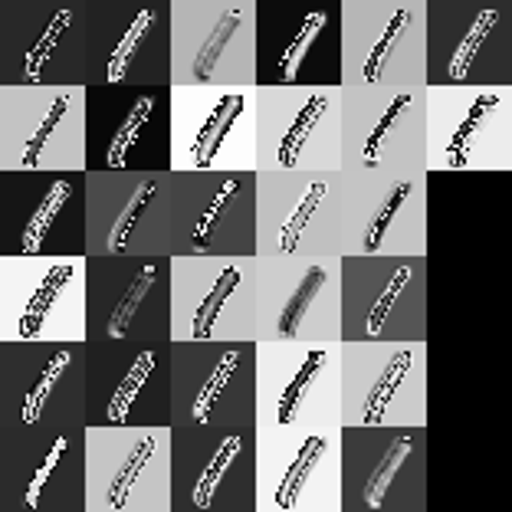

In [120]:
import taranis.core.visualization as viz 
transforms.ToPILImage()(viz.show_conv_layers(result)).resize((512, 512))

# New network with a convolution layer

From a single image it is going to learn to generate 32 new ones to better classify them

In [177]:
from torch.nn import init
from torch import Tensor
import math

import taranis.core.nn as ext_nn
        
conv_model = nn.Sequential(
    ext_nn.MaskLayer((28, 28)),
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, 1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(576 * 64, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1),
)

## Training

In [178]:
gpu_train(conv_model, batch_size=1024)

0 -0.0018089044902284267
1 -0.0019030471221875337
2 -0.0019033332749948664
3 -0.0019034002039392116
4 -0.001903429374856464
5 -0.0019034460439520367
6 -0.0019034563989962562
7 -0.0019034632181717177
8 -0.0019034685219748546
9 -0.0019034723104056665


## Compare

In [159]:
test_model(linear)
test_model(deepmodel)
test_model(conv_model.cpu())

Accuracy 92.85 7.150000000000006
Accuracy 10.11 89.89
Accuracy 98.07000000000001 1.9299999999999926


## Inspect learned Convolution Kernels

torch.Size([32, 26, 26])


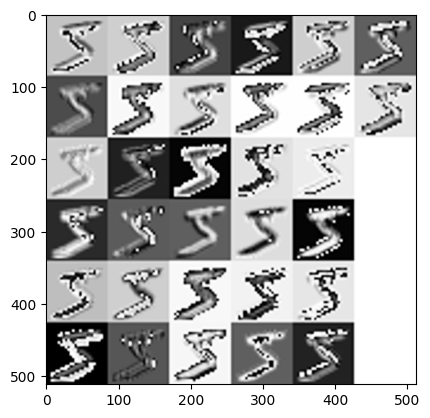

torch.Size([32, 26, 26])


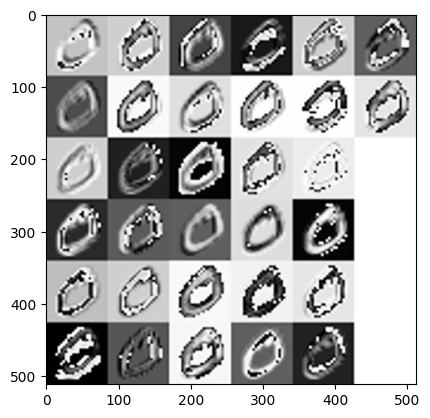

torch.Size([32, 26, 26])


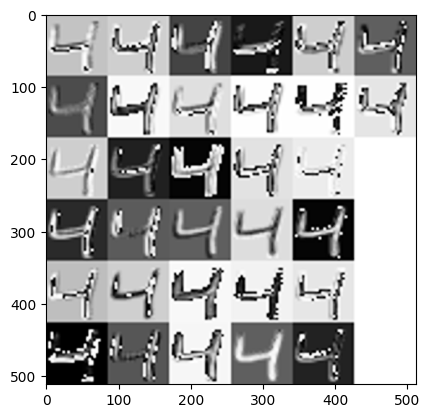

torch.Size([32, 26, 26])


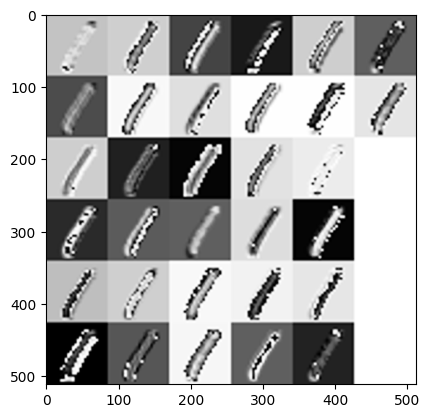

In [179]:
conv_model = conv_model.cpu()

for i in range(4):
    image, label = dataset[i]
    conv = list(conv_model.children())[1]

    batch = transforms.ToTensor()(image)
    result = conv(batch)
    print(result.shape)
    plt.imshow(transforms.ToPILImage()(viz.show_conv_layers(result)).resize((512, 512)), cmap='Greys')
    plt.show()

Softmax(dim=1) torch.Size([1, 1, 28, 28])


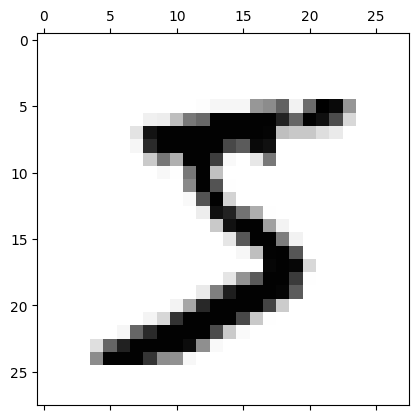

MaskLayer() torch.Size([1, 1, 28, 28])


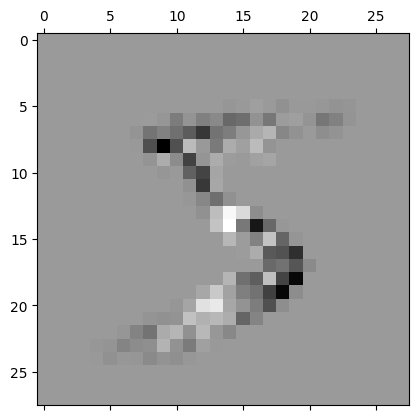

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


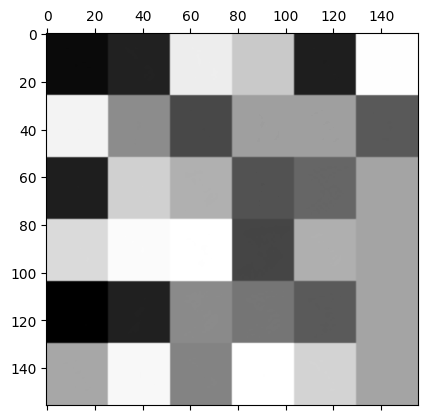

ReLU() torch.Size([1, 32, 26, 26])


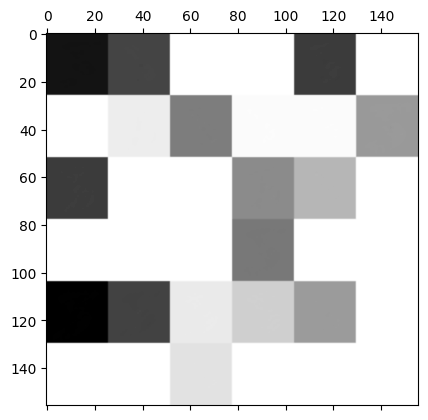

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


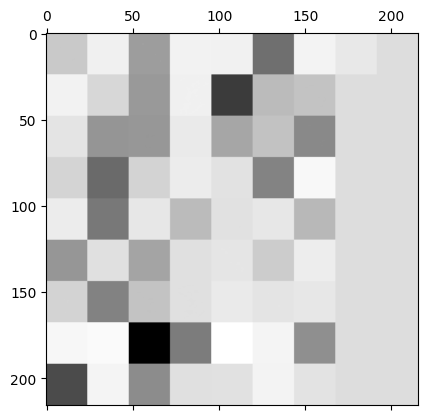

ReLU() torch.Size([1, 64, 24, 24])


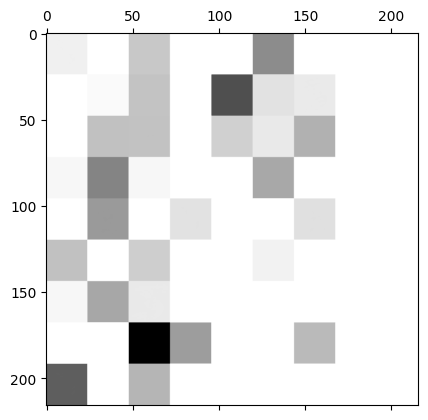

Flatten(start_dim=1, end_dim=-1) torch.Size([1, 36864])


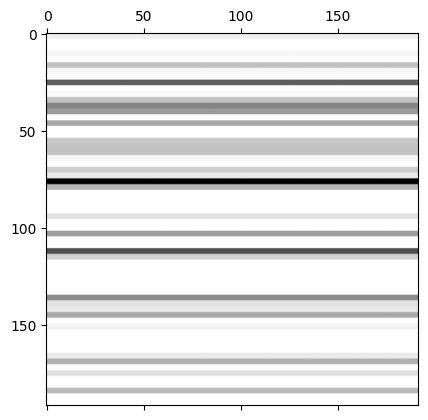

Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


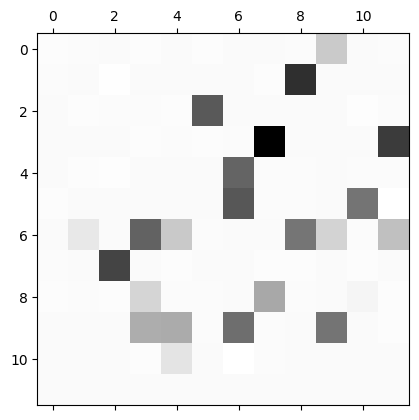

ReLU() torch.Size([1, 128])


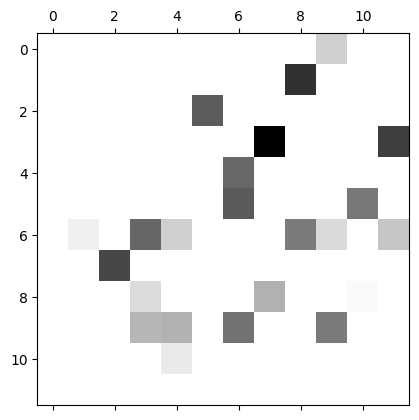

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


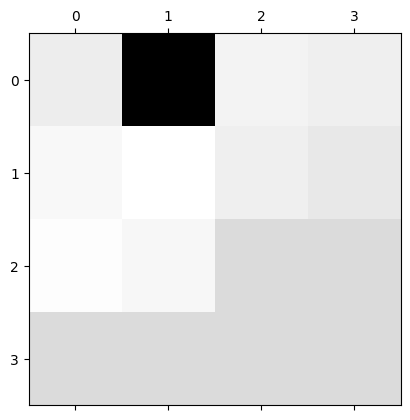

Softmax(dim=1) torch.Size([1, 10])


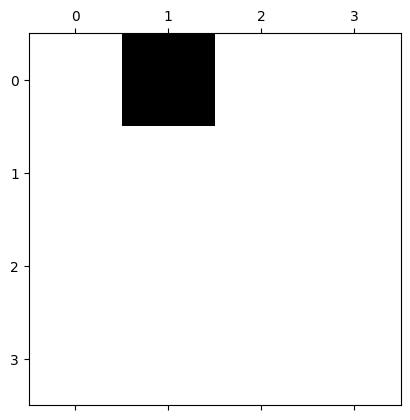

Softmax(dim=1) torch.Size([1, 1, 28, 28])


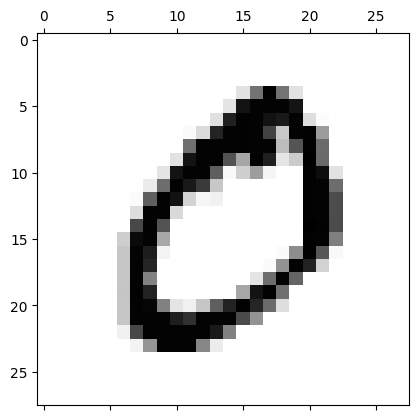

MaskLayer() torch.Size([1, 1, 28, 28])


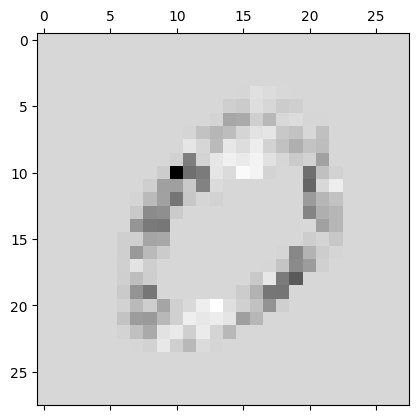

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


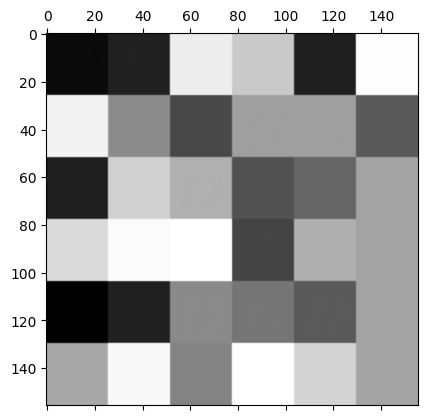

ReLU() torch.Size([1, 32, 26, 26])


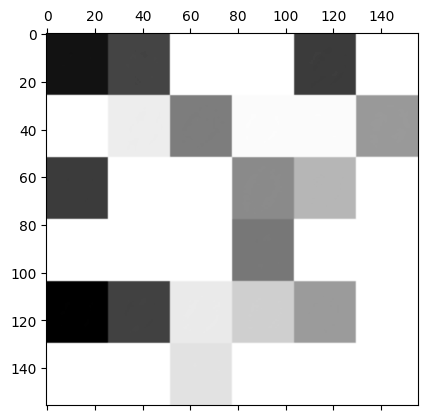

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


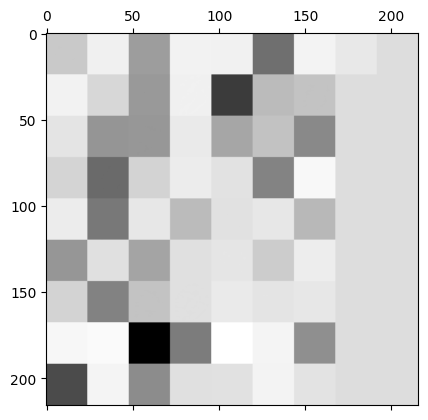

ReLU() torch.Size([1, 64, 24, 24])


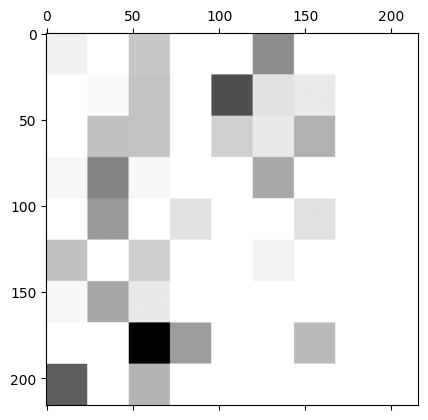

Flatten(start_dim=1, end_dim=-1) torch.Size([1, 36864])


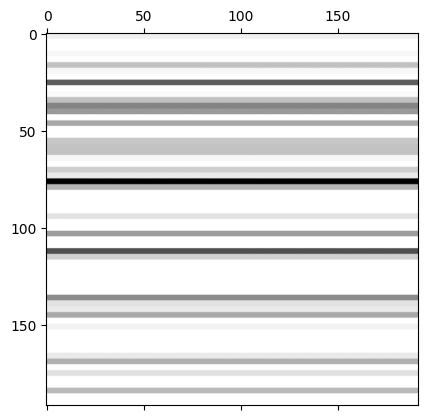

Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


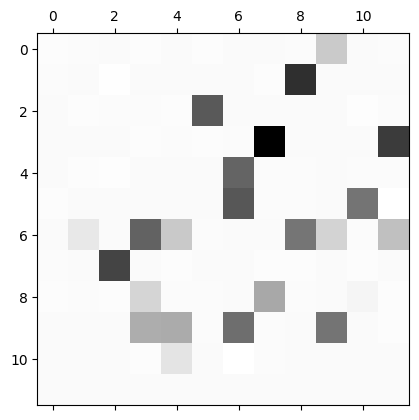

ReLU() torch.Size([1, 128])


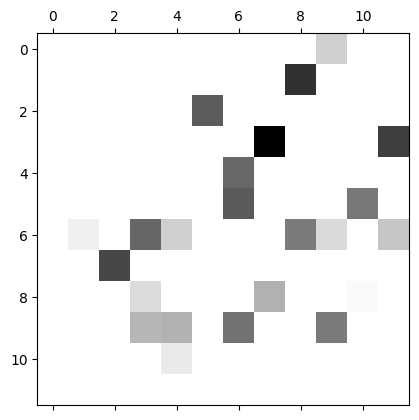

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


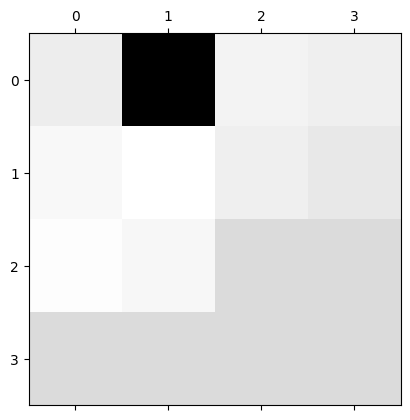

Softmax(dim=1) torch.Size([1, 10])


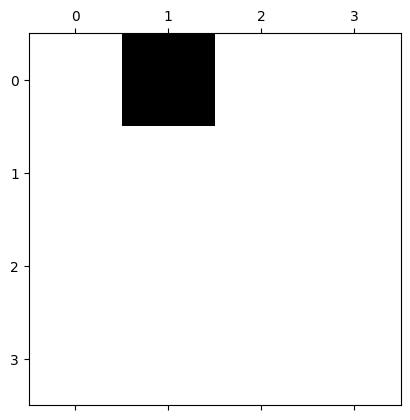

Softmax(dim=1) torch.Size([1, 1, 28, 28])


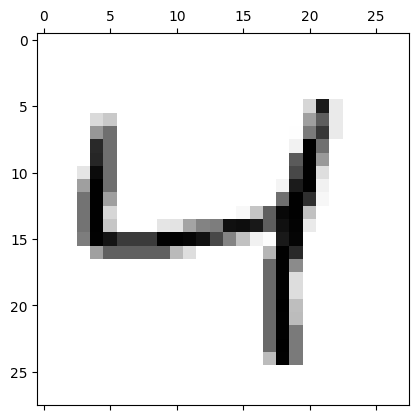

MaskLayer() torch.Size([1, 1, 28, 28])


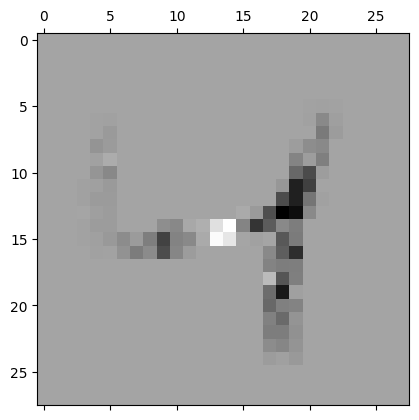

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


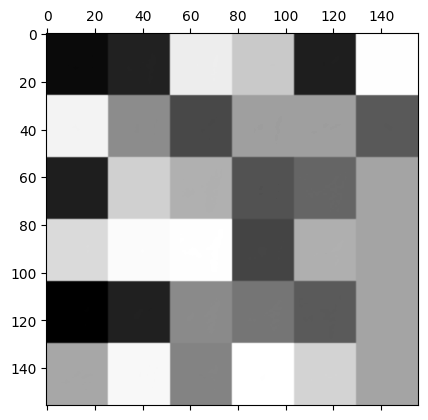

ReLU() torch.Size([1, 32, 26, 26])


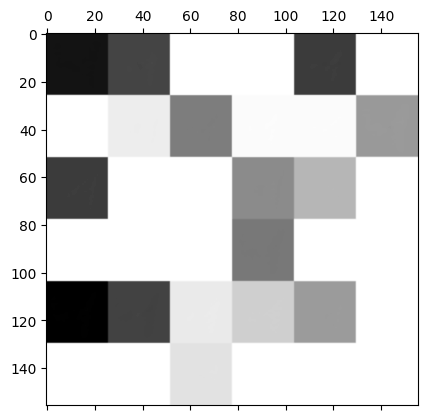

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


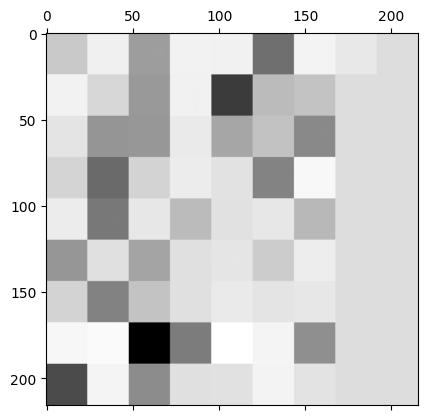

ReLU() torch.Size([1, 64, 24, 24])


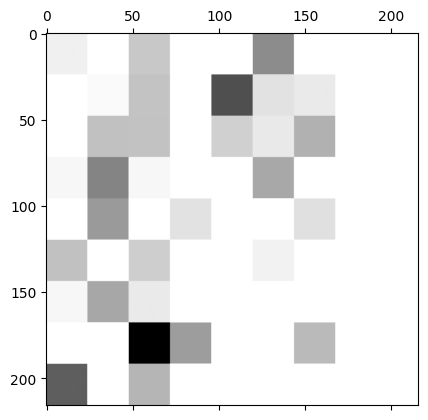

Flatten(start_dim=1, end_dim=-1) torch.Size([1, 36864])


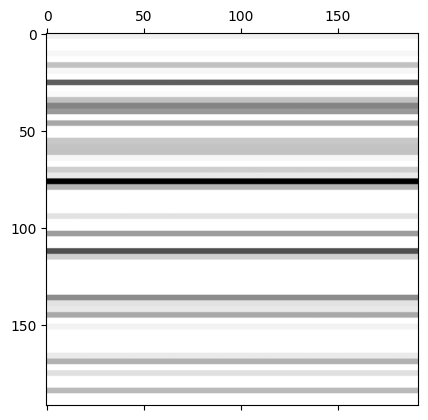

Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


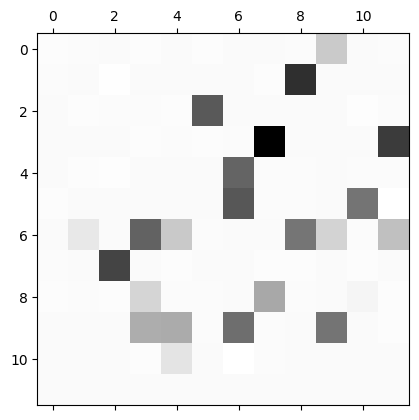

ReLU() torch.Size([1, 128])


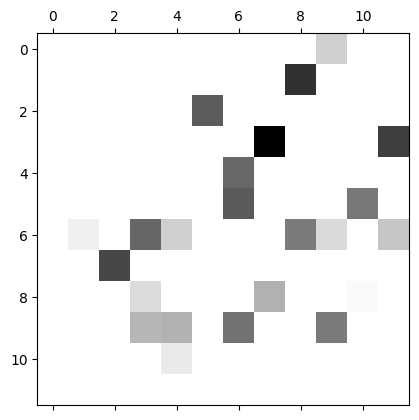

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


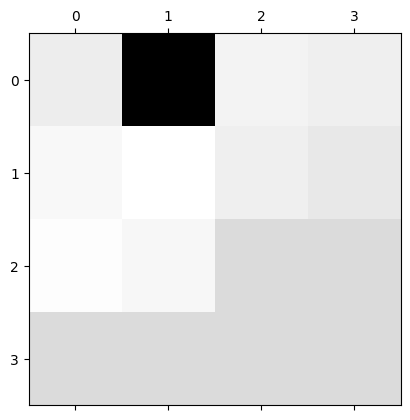

Softmax(dim=1) torch.Size([1, 10])


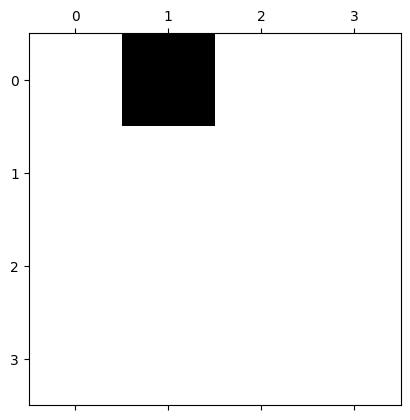

Softmax(dim=1) torch.Size([1, 1, 28, 28])


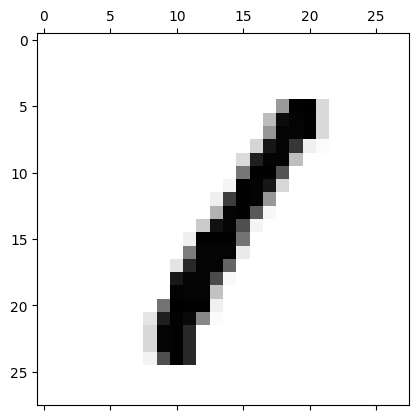

MaskLayer() torch.Size([1, 1, 28, 28])


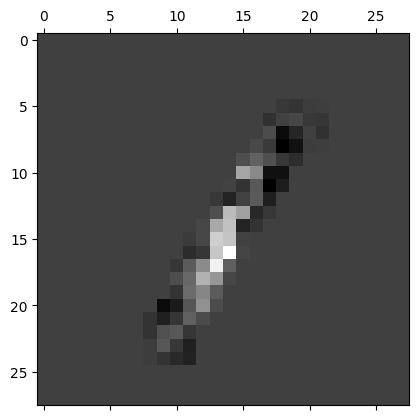

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


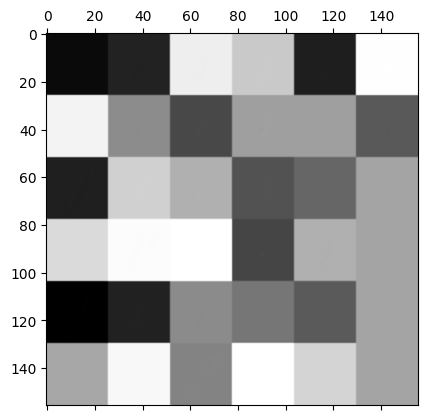

ReLU() torch.Size([1, 32, 26, 26])


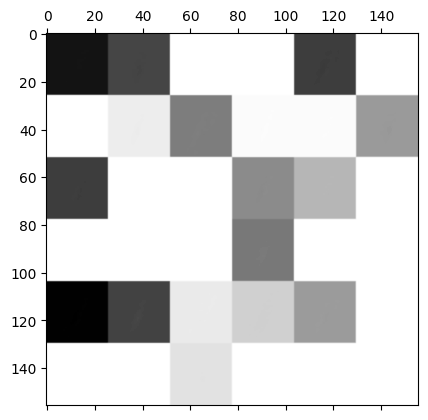

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


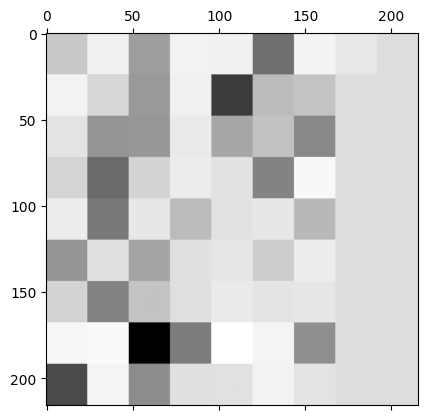

ReLU() torch.Size([1, 64, 24, 24])


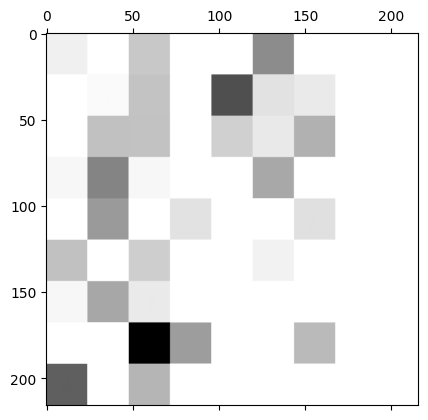

Flatten(start_dim=1, end_dim=-1) torch.Size([1, 36864])


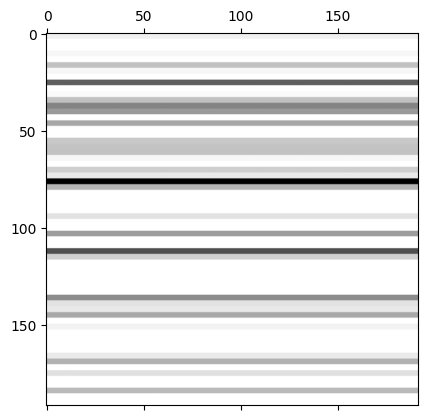

Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


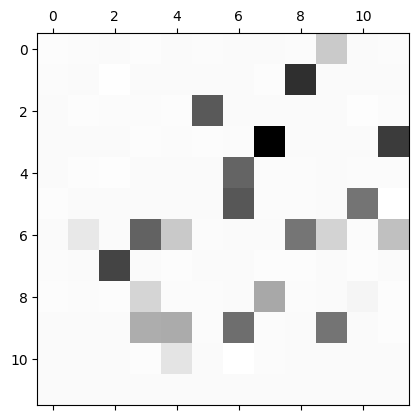

ReLU() torch.Size([1, 128])


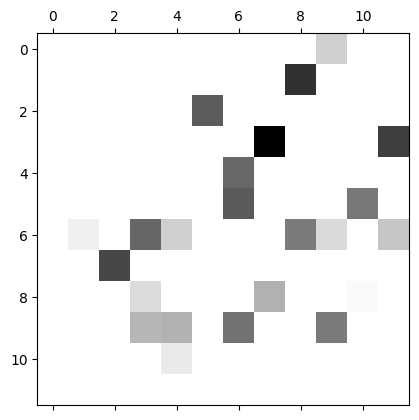

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


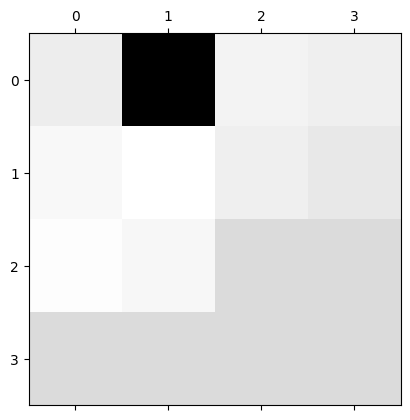

Softmax(dim=1) torch.Size([1, 10])


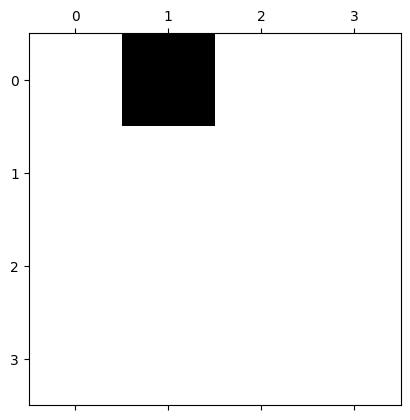

Softmax(dim=1) torch.Size([1, 1, 28, 28])


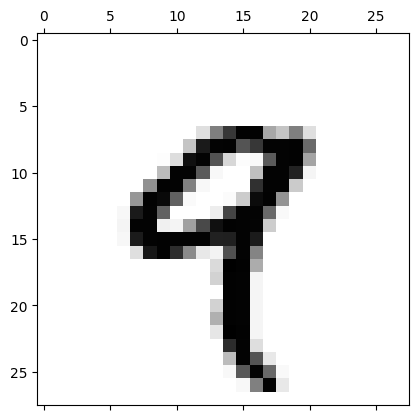

MaskLayer() torch.Size([1, 1, 28, 28])


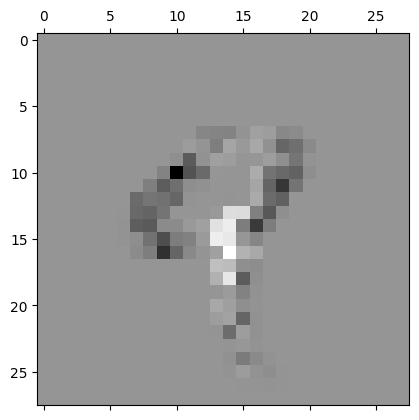

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


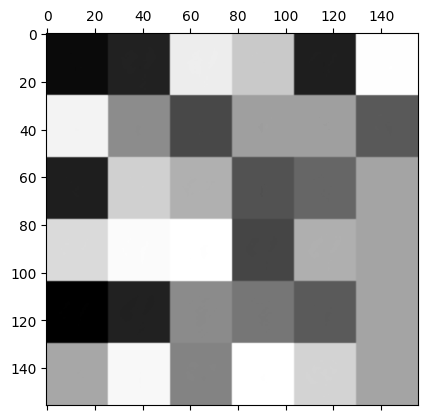

ReLU() torch.Size([1, 32, 26, 26])


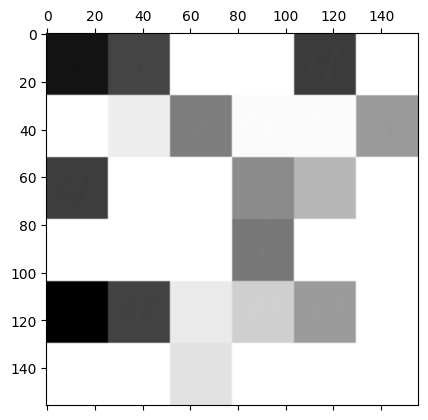

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


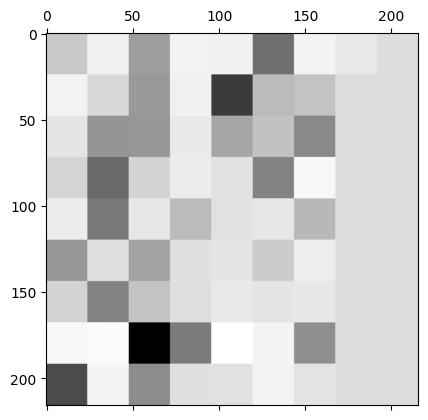

ReLU() torch.Size([1, 64, 24, 24])


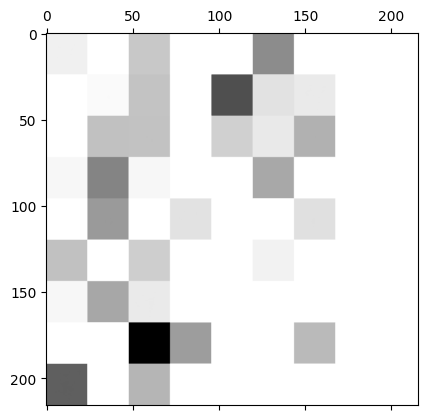

Flatten(start_dim=1, end_dim=-1) torch.Size([1, 36864])


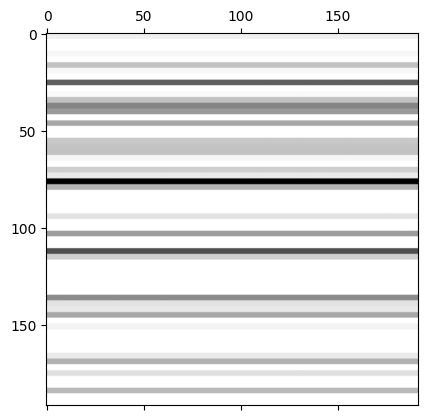

Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


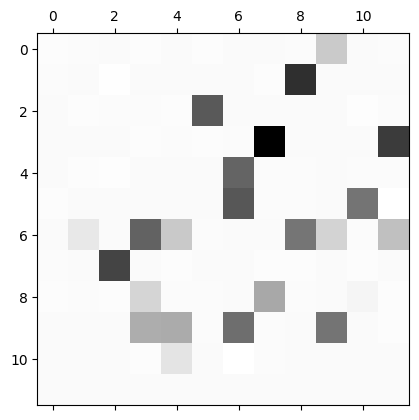

ReLU() torch.Size([1, 128])


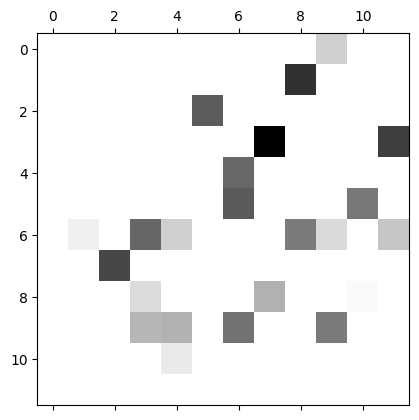

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


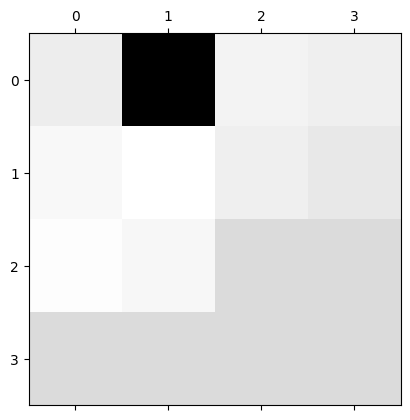

Softmax(dim=1) torch.Size([1, 10])


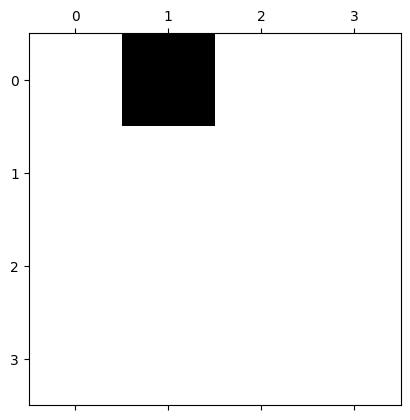

In [180]:
activations = (nn.ReLU,)

def is_perfect_square(v):
    w = int(np.sqrt(v))
    return w * w == v

prev_was_conv = False

def show_layers(layer, input, output):
    global prev_was_conv
    
    flat = nn.Flatten()(output)
    w = int(np.sqrt(flat.shape[1]))
    
    if not is_perfect_square(flat.shape[1]):
        w += 1
    
    print(layer, output.shape)
    if isinstance(layer, nn.Conv2d) or (prev_was_conv and isinstance(layer, activations)):
        img = viz.show_conv_layers(output.squeeze(0))
        prev_was_conv = True
    else:
        new = torch.zeros((w * w,), dtype=torch.float)
        new[:flat.shape[1]] = flat[:]
        img = new.view(w, w)
        prev_was_conv = False
        
    #transforms.ToPILImage()(img).resize((512, 512))
    plt.matshow(img, interpolation=None, cmap='Greys')
    plt.show()

with torch.no_grad():
    for i in range(5):
        image, label = dataset[i]

        input = transforms.ToTensor()(image).unsqueeze(0)
        show_layers(layer, input, input)
        
        for layer in list(conv_model.children()):
            output = layer(input)
            show_layers(layer, input, output)
            input = output

In [185]:
list(conv_model.children())[0].weight.abs().mean()

tensor(0.0005, grad_fn=<MeanBackward0>)